<a href="https://colab.research.google.com/github/sornavel/Hackathons-Janatahack-Jun-2020/blob/master/Image_Classification_resnet50_tfms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyDrive

In [0]:
import os
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1-1swO1d7w-0-9I_CCX_yK64G638NfKCX'})

In [5]:
download.GetContentFile('train.zip')
!unzip 'train.zip'
train_df = pd.read_csv('train.csv')

Archive:  train.zip
   creating: images/
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/1000.jpg         
  inflating: images/1001.jpg         
  inflating: images/1002.jpg         
  inflating: images/1003.jpg         
  inflating: images/1004.jpg         
  inflating: images/1005.jpg         
  inflating: images/1006.jpg         
  inflating: images/1007.jpg         
  inflating: images/1008.jpg         
  inflating: images/1009.jpg         
  inflating: images/101.jpg          
  inflating: images/1010.jpg         
  inflating: images/1011.jpg         
  inflating: images/1012.jpg         
  inflating: images/1013.jpg         
  inflating: images/1014.jpg         
  inflating: images/1015.jpg         
  inflating: images/1016.jpg         
  inflating: images/1017.jpg         
  inflating: images/1018.jpg         
  inflating: images/1019.jpg         
  inflati

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])


# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])


# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


def relu_fn(x):
    """ Swish activation function """
    return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)

class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]]*2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""
    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self,):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.

        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.

        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': 'http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth',
    'efficientnet-b1': 'http://storage.googleapis.com/public-models/efficientnet-b1-dbc7070a.pth',
    'efficientnet-b2': 'http://storage.googleapis.com/public-models/efficientnet-b2-27687264.pth',
    'efficientnet-b3': 'http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth',
    'efficientnet-b4': 'http://storage.googleapis.com/public-models/efficientnet-b4-e116e8b3.pth',
    'efficientnet-b5': 'http://storage.googleapis.com/public-models/efficientnet-b5-586e6cc6.pth',
}

def load_pretrained_weights(model, model_name, load_fc=True):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = model_zoo.load_url(url_map[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))
    
    
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block

    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above

    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = relu_fn(self._bn0(self._expand_conv(inputs)))
        x = relu_fn(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(relu_fn(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods

    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks

    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')

    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._dropout = self._global_params.dropout_rate
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = relu_fn(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = relu_fn(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """

        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        if self._dropout:
            x = F.dropout(x, p=self._dropout, training=self.training)
        x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return EfficientNet(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = EfficientNet.from_name(model_name, override_params={'num_classes': num_classes})
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet_b'+str(i) for i in range(num_models)]
        if model_name.replace('-','_') not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

In [0]:
#making model
md_ef = EfficientNet.from_pretrained('efficientnet-b5', num_classes=2)

In [0]:
def gammaCorrection(img_original, gamma):
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

    res = cv2.LUT(img_original, lookUpTable)
    return res;

def cropImage(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(cnt) for cnt in contours]

    #Calculate the combined bounding rectangle points.
    top_x = min([x for (x, y, w, h) in rects])
    top_y = min([y for (x, y, w, h) in rects])
    bottom_x = max([x+w for (x, y, w, h) in rects])
    bottom_y = max([y+h for (x, y, w, h) in rects])

    crop = gray[top_y:bottom_y,top_x:bottom_x]
    crop = cv2.resize(crop,(800,600), interpolation=cv2.INTER_CUBIC)
    return crop

def preprocessImg(inputdir, outputdir):
    imgList = os.listdir(inputdir)
    listA = len(imgList)
    gamma = 0.7
    for i in range(listA):
        img = cv2.imread(inputdir+imgList[i])
        crop = cropImage(img)
        new_image = gammaCorrection(crop,gamma)
        #improve contrast of the image
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(new_image)
        cv2.imwrite(str(outputdir+imgList[i]),cl1)
        
output_folder_train = os.path.join('../', 'output/train/')
output_folder_test = os.path.join('../', 'output/test/')
if not os.path.exists(output_folder_train):
    os.makedirs(output_folder_train)
if not os.path.exists(output_folder_test):
    os.makedirs(output_folder_test)   

In [10]:
download = drive.CreateFile({'id': '1Kr8tXO_a0RhAO7cLA41a2SqE5w7vDC42'})
download.GetContentFile('test.csv')
test_df = pd.read_csv('test.csv')
test_df.head()

import cv2

'''def get_df():
    base_image_dir = os.path.join('.')
    train_dir = os.path.join('images/')
    test_dir = os.path.join('images/')
    df = pd.read_csv('train.csv')
#    df['path'] = df['image_names']
#    df = df.drop(columns=['image_names'])
    df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
    test_df = pd.read_csv('test.csv')
    preprocessImg(train_dir,output_folder_train)
    preprocessImg(test_dir,output_folder_test)
    return df, test_df

df, test_df = get_df()'''

"def get_df():\n    base_image_dir = os.path.join('.')\n    train_dir = os.path.join('images/')\n    test_dir = os.path.join('images/')\n    df = pd.read_csv('train.csv')\n#    df['path'] = df['image_names']\n#    df = df.drop(columns=['image_names'])\n    df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe\n    test_df = pd.read_csv('test.csv')\n    preprocessImg(train_dir,output_folder_train)\n    preprocessImg(test_dir,output_folder_test)\n    return df, test_df\n\ndf, test_df = get_df()"

In [0]:
bs = 16
sz = 256
#tfms = get_transforms(do_flip=True,flip_vert=False, max_rotate=180,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)

In [0]:
##transformations to be done to images
tfms = get_transforms(do_flip=True,flip_vert=True ,max_rotate=180, max_zoom=1.25, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)
#, xtra_tfms=zoom_crop(scale=(0.9,1.8), do_rand=True, p=0.8))

## create databunch of test set to be passed
test_img = ImageList.from_df(test_df, path='images/')

In [0]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train_df, path='images/')
       .split_by_rand_pct(0.2)
       #.split_none()
       .label_from_df()
       .add_test(test_img))

In [0]:
data = (src.transform(tfms, size=500,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=16, device= torch.device('cuda:0')).normalize(imagenet_stats))

In [15]:
'''import torchvision

from fastai import *
from fastai.vision import *

def resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = torchvision.models.resnext50_32x4d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))'''

'''from fastai.metrics import error_rate # 1 - accuracy

learn = Learner(data, 
                md_ef, 
                metrics=[FBeta(beta=1, average='macro'), accuracy], 
                model_dir="models")

learn.data.add_test(ImageList.from_df(test_df,
                                      './',
                                      folder='images',
                                      suffix=''))'''

learn = cnn_learner(data, base_arch=models.resnet50, pretrained=True, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [17]:
gc.collect()

33

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.772585,0.319078,0.865682,0.869301,00:55
1,0.663890,0.678812,0.784067,0.784195,00:54
2,0.499090,0.279723,0.900881,0.902736,00:54
3,0.440343,0.375253,0.888095,0.896657,00:55
4,0.358461,0.215117,0.936062,0.939210,00:54
5,0.295807,0.166220,0.924089,0.927052,00:55
6,0.241998,0.177854,0.927342,0.930091,00:55
7,0.216353,0.215980,0.922588,0.927052,00:54
8,0.188505,0.181803,0.935877,0.939210,00:54
9,0.166935,0.158269,0.945729,0.948328,00:55


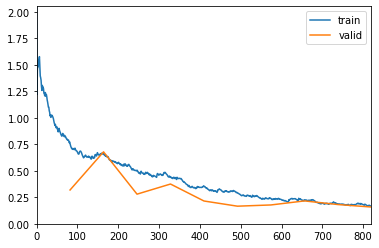

In [18]:
#lr = 2.75E-06
learn.fit_one_cycle(10, 1e-03)

epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-05


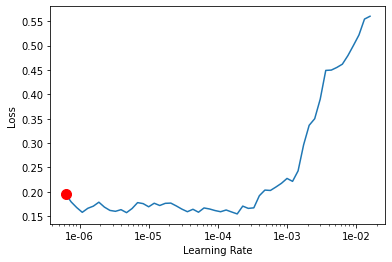

In [19]:
#lets plot the lr finder record
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.160181,0.169977,0.939172,0.942249,01:13
1,0.177692,0.180613,0.932572,0.936170,01:13
2,0.174045,0.170177,0.939172,0.942249,01:12
3,0.160140,0.153726,0.948992,0.951368,01:12
4,0.155844,0.176188,0.932572,0.936170,01:13
5,0.174149,0.151127,0.945878,0.948328,01:13


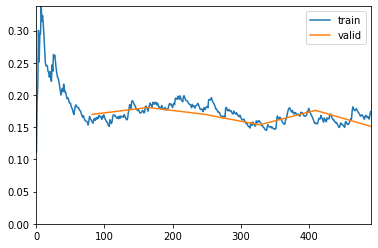

In [20]:
learn.fit_one_cycle(6,slice(5e-07,3e-06))

In [21]:
preds,y = learn.get_preds(DatasetType.Test)
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [0]:
labelled_preds = [np.argmax(preds[i]) for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [0]:
#create submission file
df = pd.DataFrame({'image_names':test_df['image_names'], 'emergency_or_not':labelled_preds}, columns=['image_names', 'emergency_or_not'])
df.to_csv('submission_resnet50.csv', index=False)

In [0]:
from google.colab import files
files.download('submission_resnet50.csv')